# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from sklearn.preprocessing import StandardScaler

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = [ '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


## Use Datetime Index

In [4]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [5]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Import And Clean Weather Data

In [6]:
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2018.csv')
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,EVAP,MDPR,MNPN,...,TMAX,TMIN,TOBS,WESD,WESF,WT01,WT03,WT04,WT05,WT11
0,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/1/2017,NaN,NaN,NaN,NaN,...,18.9,7.2,13.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/2/2017,NaN,NaN,NaN,NaN,...,19.4,7.8,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/3/2017,NaN,NaN,NaN,NaN,...,21.7,4.4,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/4/2017,NaN,NaN,NaN,NaN,...,26.7,6.7,26.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/5/2017,NaN,NaN,NaN,NaN,...,31.7,8.9,30.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.7%
EVAP percent null: 50.6%
MDPR percent null: 99.7%
MNPN percent null: 50.9%
MXPN percent null: 50.9%
PRCP percent null: 0.9%
SNOW percent null: 0.5%
SNWD percent null: 0.5%
TAVG percent null: 100.0%
TMAX percent null: 0.2%
TMIN percent null: 0.0%
TOBS percent null: 0.5%
WESD percent null: 100.0%
WESF percent null: 100.0%
WT01 percent null: 100.0%
WT03 percent null: 99.5%
WT04 percent null: 100.0%
WT05 percent null: 100.0%
WT11 percent null: 100.0%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'TAVG', 'WESD', 'WESF', 'WT01', 'WT03', 'WT04', 'WT05', 'WT11']


In [8]:
# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])

In [9]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
weather.dtypes

DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object

In [10]:
weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

In [11]:
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for datetime in df['datetime']:
            datetime = datetime.date()
            if datetime != old_datetime:
                old_datetime = datetime
                value = weather[weather['DATE'] == datetime][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 2/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 3/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 4/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN


### Import and Clean Wind Data

In [12]:
weather_files = ['../../data/raw_data/weather/provo_airport_2017', '../../data/raw_data/weather/provo_airport_2018']
# the array to store the readings in
contents = []

# Extract the weather data in the ISD format
for file in weather_files:
    contents.append(hf.extract_weather_data(file))


In [13]:
# the dfs containing the wind information for the readings.
wind_frame_2017 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2018 = pd.DataFrame(columns=["angle","speed"])


wind_frames = [wind_frame_2017, wind_frame_2018]
for i in range(len(contents)):
    wind_dict = {}
    for reading in contents[i]:
        reading.GPO_timestamp = hf.round_time(reading.GPO_timestamp)

        # no key value made yet
        if reading.GPO_timestamp not in wind_dict.keys():
            # check to see if the readings are valid
            # Sets them to 'invalid' so that when we inpute them it can be handled
            if reading.WO_wind_angle == '999':
                reading.WO_wind_angle = np.nan
            else:
                reading.WO_wind_angle = int(reading.WO_wind_angle)
            if reading.WO_wind_speed == '9999':
                reading.WO_wind_speed = np.nan
            else:
                reading.WO_wind_speed = int(reading.WO_wind_speed)
            wind_dict[reading.GPO_timestamp] = [reading.WO_wind_angle, reading.WO_wind_speed]
    wind_frames[i] = pd.DataFrame.from_dict(wind_dict, orient='index')
    wind_frames[i] = wind_frames[i].rename(columns={0:'Wind Angle', 1:'Wind Speed'})

In [14]:
#we need to join the wind data now to the existing dataframes, but the dont care about

for i in range(len(train_dfs)):
    # train dfs is the 2017 data set so we need to set the wind frame to that 
    # dataset
    train_dfs[i] = train_dfs[i].join(wind_frames[0])
for i in range(len(test_dfs)):
    # test dfs is the 2018 data set so we need to set the wind frame to that
    # dataset
    test_dfs[i] = test_dfs[i].join(wind_frames[1])

In [15]:
for i in range(len(train_dfs)):
    train_dfs[i]['Wind Angle'] = train_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    train_dfs[i]['Wind Speed'] = train_dfs[i]['Wind Speed'].interpolate(limit_direction='both')
for i in range(len(test_dfs)):
    #test dfs is the 2018 data set so we need to set the wind frame to that dataset
    test_dfs[i]['Wind Angle'] = test_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    test_dfs[i]['Wind Speed'] = test_dfs[i]['Wind Speed'].interpolate(limit_direction='both')

In [16]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [17]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,255.0,55.5
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,210.0,49.0


## Create Window Slice Features
Here we will create 4 1-week windows of the 28-day feature window. 

In [18]:
x_win_size = pd.Timedelta('28 days')
num_slices = 4
custom_x_win = x_win_size / num_slices
print("x win size:", x_win_size)
print("Custom x win:", custom_x_win)
custom_params = {}
new_columns = []
for df in test_dfs + train_dfs:
    for col in x_columns:
        for i in range(num_slices):
            new_col = col + "_slice_" + str(i + 1)
            df[new_col] = df[col].copy()
            # Create a custom parameter for each feature
            current_slice = num_slices - i
            separation = current_slice - 1
            custom_params[new_col] = {
                'x_win_size': custom_x_win,
                'separation': separation * custom_x_win}
            print("Current separation size:", custom_params[new_col]['separation'])
            new_columns.append(new_col)
x_columns = list(set(x_columns + new_columns))
train_dfs[test_index].head(5)


x win size: 28 days 00:00:00
Custom x win: 7 days 00:00:00
Current separation size: 21 days 00:00:00
Current separation size: 14 days 00:00:00
Current separation size: 7 days 00:00:00
Current separation size: 0 days 00:00:00
Current separation size: 21 days 00:00:00
Current separation size: 14 days 00:00:00
Current separation size: 7 days 00:00:00
Current separation size: 0 days 00:00:00
Current separation size: 21 days 00:00:00
Current separation size: 14 days 00:00:00
Current separation size: 7 days 00:00:00
Current separation size: 0 days 00:00:00
Current separation size: 21 days 00:00:00
Current separation size: 14 days 00:00:00
Current separation size: 7 days 00:00:00
Current separation size: 0 days 00:00:00
Current separation size: 21 days 00:00:00
Current separation size: 14 days 00:00:00
Current separation size: 7 days 00:00:00
Current separation size: 0 days 00:00:00
Current separation size: 21 days 00:00:00
Current separation size: 14 days 00:00:00
Current separation size: 7 

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,...,Turbidity (NTU)_slice_3,Turbidity (NTU)_slice_4,ODOSat%_slice_1,ODOSat%_slice_2,ODOSat%_slice_3,ODOSat%_slice_4,ODO (mg/L)_slice_1,ODO (mg/L)_slice_2,ODO (mg/L)_slice_3,ODO (mg/L)_slice_4
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,...,16.84,16.84,90.2,90.2,90.2,90.2,9.04,9.04,9.04,9.04
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,...,16.76,16.76,90.2,90.2,90.2,90.2,9.04,9.04,9.04,9.04
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,...,16.82,16.82,90.1,90.1,90.1,90.1,9.04,9.04,9.04,9.04
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,...,17.19,17.19,90.0,90.0,90.0,90.0,9.03,9.03,9.03,9.03
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,...,16.85,16.85,89.8,89.8,89.8,89.8,9.02,9.02,9.02,9.02


## Greedy Model

In [19]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

max_iter = 25000
loss = "log"

# Windowize
print("Windowizing 2017 data sets")
train = hf.windowize(train_dfs[0], 'datetime', target_column, 
                     x_win_size=x_win_size,
                     custom_parameters=custom_params)
train = train.append(hf.windowize(train_dfs[1], 'datetime', target_column,
                                  x_win_size=x_win_size,
                                  custom_parameters=custom_params))
print("Windowizing 2018 data sets")
test = hf.windowize(test_dfs[0], 'datetime', target_column, 
                    x_win_size=x_win_size,
                    custom_parameters=custom_params)
test = test.append(hf.windowize(test_dfs[1], 'datetime', target_column, 
                                x_win_size=x_win_size,
                                custom_parameters=custom_params))
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Sort columns by accuracy
model = SGDClassifier(max_iter=max_iter, loss=loss)
sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                            test,
                                            x_columns,
                                            'bloom', verbose=0)
# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
    model, train, test, x_columns,'bloom', sorted_columns )

Windowizing 2017 data sets
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'pH_slice_4', 'ODOSat%', 'ODOSat%_slice_4', 'Temp C', 'Temp C_slice_1', 'pH_slice_3', 'ODOSat%_slice_3', 'pH', 'Temp C_slice_2', 'pH (mV)_slice_2', 'TMAX', 'Temp C_slice_3', 'pH_slice_2', 'ODO (mg/L)_slice_4', 'ODO (mg/L)_slice_3', 'pH (mV)', 'Temp C_slice_4', 'ODO (mg/L)', 'pH (mV)_slice_3', 'pH (mV)_slice_4', 'Wind Speed', 'ODOSat%_slice_2', 'PRCP', 'Turbidity (NTU)_slice_3', 'rainy', 'Turbidity (NTU)', 'Turbidity (NTU)_slice_4', 'Wind Angle', 'ODOSat%_slice_1', 'SNWD', 'pH_slice_1', 'ODO (mg/L)_slice_2', 'pH (mV)_slice_1', 'SNOW', 'Turbidity (NTU)_slice_1', 'Turbidity (NTU)_slice_2', 'ODO (mg/L)_slice_1', 'Sp Cond (uS/cm)_slice_4', 'Sp Cond (uS/cm)', 'Sp Cond (uS/cm)_slice_3', 'Sp Cond (uS/cm)_slice_2', 'Sp Cond (uS/cm)_slice_1']
adjusted sorted_columns: ['TMIN', 'pH_slice_4', 'ODOSat%', 'ODOSat%_slice_4', 'Temp C', 'Temp C_slice_1', 'pH_slice_3', 'ODOSat%_slice_3', 'pH', 'Temp C_slice_2', 'pH (mV)_slice_2', 'TMAX', 'Temp C_slice_3', 'pH_sli

Test model accuracy: 0.8277591973244147
Test model recall: 0.8753315649867374
Test model precision: 0.8549222797927462

Training model with: ['TMIN', 'pH_slice_3', 'Wind Speed', 'ODO (mg/L)_slice_1']
Test model accuracy: 0.725752508361204
Test model recall: 0.8514588859416445
Test model precision: 0.7482517482517482

Training model with: ['TMIN', 'pH_slice_3', 'Wind Speed', 'Sp Cond (uS/cm)_slice_4']
Test model accuracy: 0.6705685618729097
Test model recall: 0.6684350132625995
Test model precision: 0.7777777777777778

Training model with: ['TMIN', 'pH_slice_3', 'Wind Speed', 'Sp Cond (uS/cm)']
Test model accuracy: 0.8361204013377926
Test model recall: 0.8806366047745358
Test model precision: 0.8623376623376623

Updating greedy model

Training model with: ['TMIN', 'pH_slice_3', 'Wind Speed', 'Sp Cond (uS/cm)', 'Sp Cond (uS/cm)_slice_3']
Test model accuracy: 0.81438127090301
Test model recall: 0.8726790450928382
Test model precision: 0.8392857142857143

Training model with: ['TMIN', 'pH_

In [20]:
temp = hf.windowize(train_dfs[0], 'datetime', target_column, 
                     custom_parameters=custom_params)
lrf.add_target_column([temp], threshold=RFU_THRESHOLD)



Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...


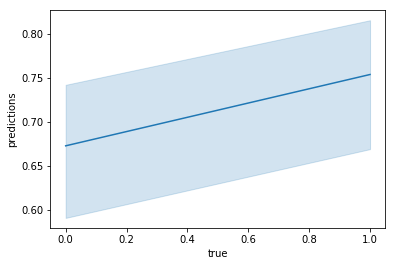

In [21]:
# Plot Predictions vs true
df = pd.DataFrame({'predictions':predictions[0:len(temp['bloom'])], 
              'true':temp['bloom'].values})
sns.lineplot(data=df, x='true', y='predictions')